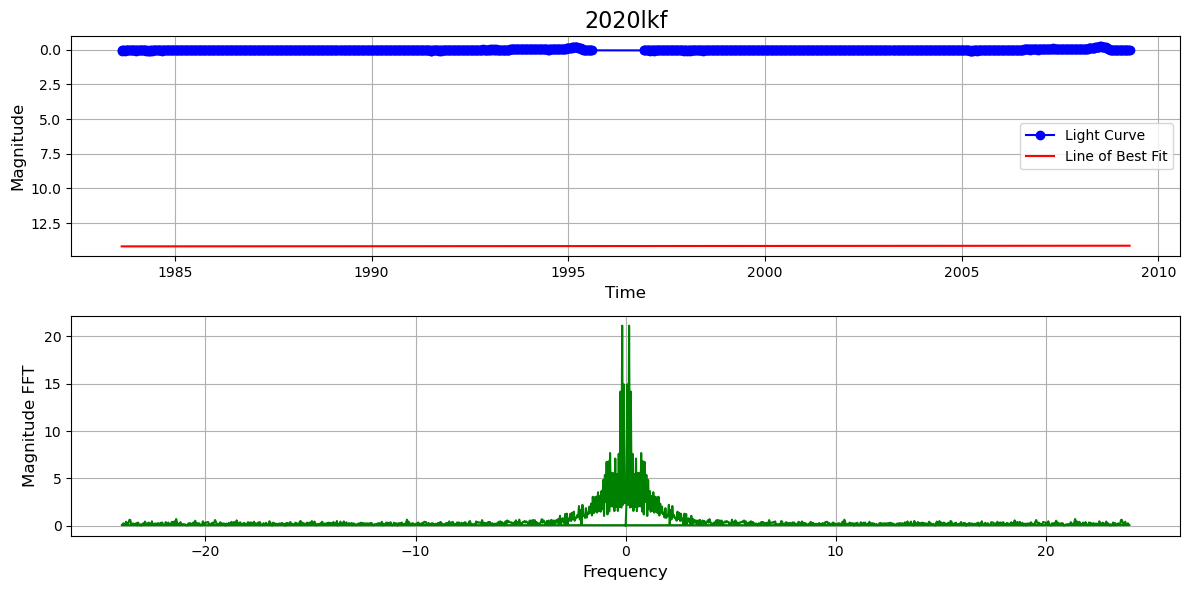

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

def compute_fourier_transform(df):
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['Time'], df['Magnitude'])
    line = slope * df['Time'] + intercept
    
    # Remove the mean magnitude to eliminate the DC component
    magnitude_mean = np.mean(df['Magnitude'])
    df['Magnitude'] -= magnitude_mean
    
    # Compute the Fourier Transform of the magnitude
    mag_fft = np.fft.fft(df['Magnitude'])
    freqs = np.fft.fftfreq(len(df['Time']), df['Time'][1] - df['Time'][0])
    
    return freqs, mag_fft, slope, intercept

def plot_light_curve_with_fft(txt_file, delimiter=r"\s+", title="Light Curve"):
    # Read the .txt file into a DataFrame
    try:
        df = pd.read_csv(txt_file, delimiter=delimiter, skiprows=2, header=None, usecols=[1,4], names=['Time', 'Magnitude'])
    except pd.errors.EmptyDataError:
        print(f"The file '{txt_file}' is empty.")
        return
    except pd.errors.ParserError:
        print(f"Error parsing '{txt_file}'. Please check the file format.")
        return
    
    freqs, mag_fft, slope, intercept = compute_fourier_transform(df)
    
    # Plot the light curve and its Fourier Transform
    plt.figure(figsize=(12, 6))
    
    plt.subplot(2, 1, 1)
    plt.plot(df['Time'], df['Magnitude'], marker='o', linestyle='-', color='blue', label='Light Curve')
    plt.plot(df['Time'], slope * df['Time'] + intercept, color='red', label='Line of Best Fit')
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Magnitude', fontsize=12)
    plt.title(title, fontsize=16)
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(freqs, np.abs(mag_fft), color='green')
    plt.xlabel('Frequency', fontsize=12)
    plt.ylabel('Magnitude FFT', fontsize=12)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage:
txt_file = r"C:\Users\nic51\TESS RESEARCH\Extracted_tarballs\sector25\cam4_ccd1\lc_discovery\lc_2020lkf_cleaned.txt"
delimiter = r"\s+"  # Change this to the appropriate delimiter (e.g., ',', ' ', etc.)
title = "2020lkf"  # Change this to the appropriate title
plot_light_curve_with_fft(txt_file, delimiter, title)


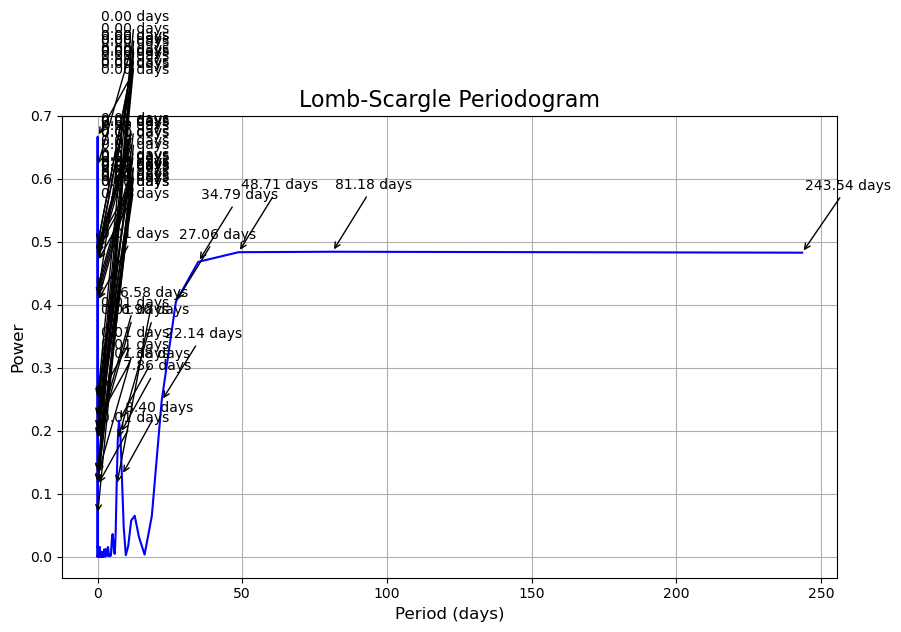

In [18]:
import numpy as np
import pandas as pd
from astropy.timeseries import LombScargle
import matplotlib.pyplot as plt

def plot_lomb_scargle_periodogram(txt_file, delimiter=r"\s+", significance_threshold=0.1):
    # Read the .txt file into a DataFrame
    try:
        df = pd.read_csv(txt_file, delimiter=delimiter, skiprows=2, header=None, usecols=[1,4], names=['Time', 'Magnitude'])
    except pd.errors.EmptyDataError:
        print(f"The file '{txt_file}' is empty.")
        return
    except pd.errors.ParserError:
        print(f"Error parsing '{txt_file}'. Please check the file format.")
        return

    # Compute Lomb-Scargle periodogram
    frequency, power = LombScargle(df['Time'], df['Magnitude']).autopower()
    
    # Estimate periods from the periodogram
    periods = 1 / frequency[power > significance_threshold * np.max(power)]
    power_peaks = power[power > significance_threshold * np.max(power)]
    
    # Filter out peaks close to 0
    tolerance = 1e-6  # Adjust as needed
    non_zero_indices = np.abs(periods) > tolerance
    periods = periods[non_zero_indices]
    power_peaks = power_peaks[non_zero_indices]
    
    # Plot Lomb-Scargle periodogram
    plt.figure(figsize=(10, 6))
    plt.plot(1/frequency, power, color='blue')
    plt.xlabel('Period (days)', fontsize=12)
    plt.ylabel('Power', fontsize=12)
    plt.title('Lomb-Scargle Periodogram', fontsize=16)
    plt.grid(True)

    # Annotate peaks
    for period, peak_power in zip(periods, power_peaks):
        # Check if the annotation overlaps with previous annotations
        x_position = period + 1
        y_position = peak_power + 0.1
        for x, y in zip(periods, power_peaks):
            if abs(x - x_position) < 1 and abs(y - y_position) < 0.1:
                y_position += 0.1
        plt.annotate(f'{period:.2f} days', xy=(period, peak_power), xytext=(x_position, y_position), arrowprops=dict(facecolor='black', arrowstyle='->'))

    plt.show()

# Example usage:
txt_file = r"C:\Users\nic51\TESS RESEARCH\Extracted_tarballs\sector27\cam4_ccd1\lc_discovery\lc_2020ork_cleaned.txt"
delimiter = r"\s+"  # Change this to the appropriate delimiter (e.g., ',', ' ', etc.)
plot_lomb_scargle_periodogram(txt_file, delimiter)
